# Setting up the environment

In this section, we import all the necessary libraries that will be used in this notebook. These include libraries for data manipulation, machine learning model creation, evaluation, and visualization.

In [1]:
# Import necessary libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib  # For loading the saved model
import json

In [2]:
# Start tracking time for performance evaluation
start_time = time.time()

# Load Pre-Trained Model and Selected Features

The model and selected features are loaded from files in the `Models` folder.

In [3]:
model_file = 'Models/PD_CF1_n1_c5_delta_xb40.joblib'
features_file = 'Models/PD_CF1_n1_c5_delta_xb40.json'

In [4]:
# Load pre-trained model
if not os.path.exists(model_file):
    raise FileNotFoundError(f"Model file {model_file} not found.")
model = joblib.load(model_file)

In [5]:
# Load selected features
if not os.path.exists(features_file):
    raise FileNotFoundError(f"Features file {features_file} not found.")
with open(features_file, 'r') as f:
    selected_features = json.load(f)['features']

# Dataset Configuration

Set paths to input files.

In [6]:
dataset_name = 'PD_CF1'
reduction_method = '_n1_c5_delta'
input_file = os.path.join('Input', f'{dataset_name}{reduction_method}.csv')
output_file = f'{dataset_name}{reduction_method}_xb30'

In [7]:
# Load data from CSV, raising an error if file is missing
if not os.path.exists(input_file):
    raise FileNotFoundError(f"Input file {input_file} not found.")
df = pd.read_csv(input_file)

# Feature Engineering

This function adds new features such as sine/cosine transformations for the 'week' column and growth rates for vegetation indices.

In [8]:
def add_features(df):
    df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
    df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)
    df['growth_rate_ndvi'] = df['veg_max_ndvi'] - df['veg_min_ndvi']
    df['growth_rate_evi'] = df['veg_max_evi'] - df['veg_min_evi']
    df['growth_rate_lai'] = df['veg_max_lai'] - df['veg_min_lai']
    df['mean_combined_vegetation_index'] = (df['veg_mean_evi'] + df['veg_mean_ndvi'] + df['veg_mean_lai']) / 3
    return df

In [9]:
# Apply feature engineering
df = add_features(df)

# Using Full Dataset for Model Evaluation

Fit the model on the entire dataset and calculate metrics without splitting the data.

In [10]:
X = df[selected_features]
y = df["Mean"]

# Using the full dataset for training and evaluation
model.fit(X, y)
y_pred = model.predict(X)

# Calculate Metrics

Define a function to calculate model performance metrics including RMSE, R², and MAE.

In [11]:
def calculate_metrics(y_true, y_pred, X=None):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    aic = None
    if X is not None:
        aic = 2 * len(X.columns) + len(X) * np.log(rmse ** 2)  # Optional AIC Calculation
    return rmse, r2, mae, aic

In [12]:
# Calculate metrics for the full dataset
rmse, r2, mae, _ = calculate_metrics(y, model.predict(X), X)

# Plotting Feature Importance

We plot the feature importance of the final model using the features selected during the previous training process.

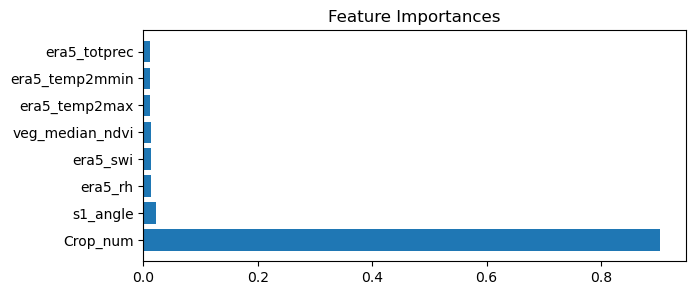

In [13]:
def plot_feature_importance(model, X, output_file):
    fig, ax = plt.subplots(figsize=(7, 3))
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    ax.barh(range(X.shape[1]), importances[indices])
    ax.set_yticks(range(X.shape[1]))
    ax.set_yticklabels(X.columns[indices])
    ax.set_title(f"Feature Importances")
    plt.show()

# Call feature importance plot function
plot_feature_importance(model, X, output_file)

# Save Results DataFrame

Create and save a DataFrame that includes observed and predicted yields, along with crop type, field ID, year, and week.

In [14]:
def create_results_df(X, y, model):
    return pd.DataFrame({
        'Yield_mean': y,
        'Predicted_Yield': model.predict(X),
        'Crop_type': df['Crop_type'].reset_index(drop=True),
        'FIELDID': df['FIELDID'].reset_index(drop=True),
        # 'Year': df['Year'].reset_index(drop=True),
        'Week': df['week'].reset_index(drop=True),
        'Data_Type': ['Full'] * len(y)
    })

In [15]:
# Create results DataFrame
results_df = create_results_df(X, y, model)

# Plot Time Series Scatter for Maize and Soy

Generate time series scatter plots for Maize and Soy data showing observed vs. predicted yields over time.

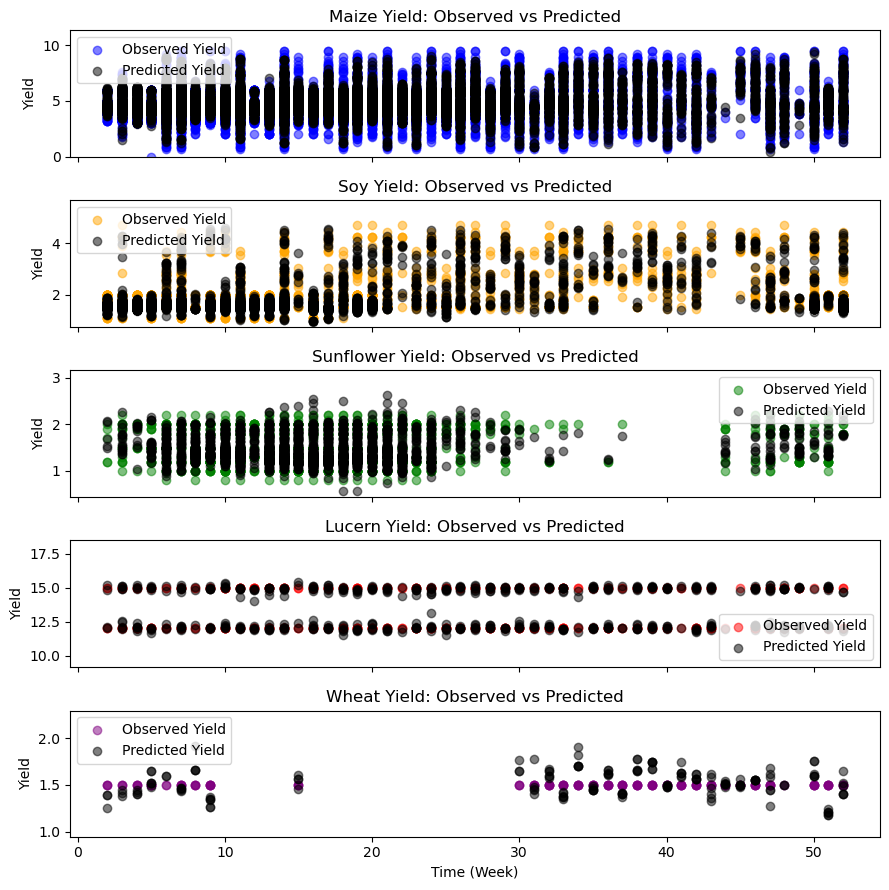

In [16]:
def plot_time_series_scatter(results_df):
    # Filtering data for each crop type
    crop_types = ['Maize', 'Soy', 'Sunflower', 'Lucern', 'Wheat']
    crop_data = {crop: results_df[results_df['Crop_type'] == crop].sort_values(by=['Week']) for crop in crop_types}

    # Creating a subplot for each crop type
    fig, axes = plt.subplots(nrows=len(crop_types), ncols=1, figsize=(9, 9), sharex=True)

    colors = ['blue', 'orange', 'green', 'red', 'purple']  # Different colors for distinction

    for i, crop in enumerate(crop_types):
        if not crop_data[crop].empty:
            crop_time = crop_data[crop]['Week']
            observed_yield = crop_data[crop]['Yield_mean']
            predicted_yield = crop_data[crop]['Predicted_Yield']

            # Determine the y-axis limit to increase visibility
            y_max = max(observed_yield.max(), predicted_yield.max()) * 1.2  # Adding 20% buffer
            y_min = min(observed_yield.min(), predicted_yield.min()) * 0.8  # Reducing 20% buffer

            axes[i].scatter(crop_time, observed_yield, label='Observed Yield', color=colors[i], alpha=0.5)
            axes[i].scatter(crop_time, predicted_yield, label='Predicted Yield', color='black', alpha=0.5)
            axes[i].set_title(f'{crop} Yield: Observed vs Predicted')
            axes[i].set_ylabel('Yield')
            axes[i].set_ylim(y_min, y_max)  # Set adjusted y-axis limits
            axes[i].legend()

    # Set x-axis label only for the last plot
    axes[-1].set_xlabel('Time (Week)')

    # Save and show plot
    plt.tight_layout()
    plt.show()

# Call the function
plot_time_series_scatter(results_df)


# Plot Time Series Scatter for Selected Fields (Maize and Soy)

Generate time series scatter plots for selected Maize and Soy fields showing observed vs. predicted yields.

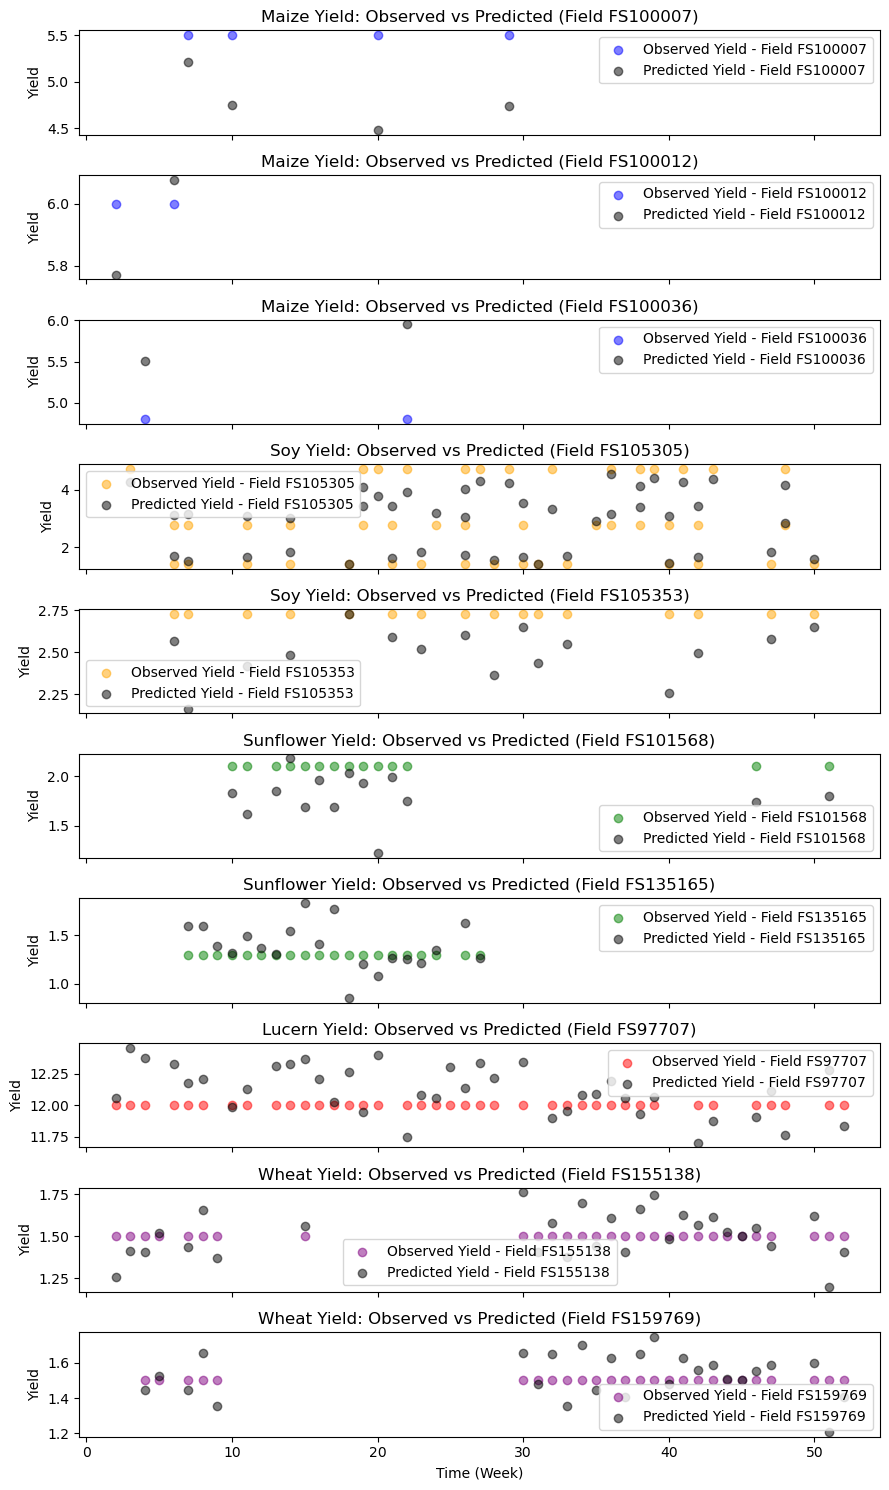

In [17]:
def plot_selected_fields(results_df, selected_fields_dict):
    crop_types = ['Maize', 'Soy', 'Sunflower', 'Lucern', 'Wheat']
    
    # Filter the dataset for each crop
    crop_data = {crop: results_df[results_df['Crop_type'] == crop] for crop in crop_types}
    
    # Extract unique FIELDIDs for each crop
    field_ids = {crop: sorted(crop_data[crop]['FIELDID'].unique()) for crop in crop_types}
    
    # Validate selected fields
    valid_fields = {
        crop: [field_ids[crop][idx - 1] for idx in selected_fields_dict.get(crop, []) if idx <= len(field_ids[crop])]
        for crop in crop_types
    }

    # Check if at least one field is valid for plotting
    if all(len(fields) == 0 for fields in valid_fields.values()):
        print("Error: No valid fields selected for plotting.")
        return

    # Define the number of subplots needed
    total_plots = sum(len(fields) for fields in valid_fields.values())
    fig, axes = plt.subplots(nrows=total_plots, ncols=1, figsize=(9, 1.5 * total_plots), sharex=True)

    if total_plots == 1:
        axes = [axes]  # Ensure axes is iterable if only one subplot is created

    colors = {
        'Maize': 'blue',
        'Soy': 'orange',
        'Sunflower': 'green',
        'Lucern': 'red',
        'Wheat': 'purple'
    }

    plot_index = 0

    # Loop through each crop and plot selected fields
    for crop in crop_types:
        for selected_field in valid_fields[crop]:
            crop_df_selected = crop_data[crop][crop_data[crop]['FIELDID'] == selected_field]
            crop_df_selected = crop_df_selected.sort_values(by=['Week'])  # Sort by Week
            crop_time = crop_df_selected['Week']  # Use Week as the time axis

            axes[plot_index].scatter(crop_time, crop_df_selected['Yield_mean'], label=f'Observed Yield - Field {selected_field}', color=colors[crop], alpha=0.5)
            axes[plot_index].scatter(crop_time, crop_df_selected['Predicted_Yield'], label=f'Predicted Yield - Field {selected_field}', color='black', alpha=0.5)
            axes[plot_index].set_title(f'{crop} Yield: Observed vs Predicted (Field {selected_field})')
            axes[plot_index].set_ylabel('Yield')
            axes[plot_index].legend()

            plot_index += 1

    # Set x-axis label only for the last plot
    axes[-1].set_xlabel('Time (Week)')

    # Adjust layout and save the figure
    plt.tight_layout()
    # plt.savefig(output_file)
    plt.show()

# Example selected fields dictionary (Modify as needed)
selected_fields_dict = {
    'Maize': [1, 2, 3],
    'Soy': [1, 2],
    'Sunflower': [1, 2],
    'Lucern': [1],
    'Wheat': [1, 2]
}

# Call plot for selected fields
plot_selected_fields(results_df, selected_fields_dict)


# Execution Time

Print the total time taken for the script to execute.

In [18]:
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 5.041422128677368 seconds
